## 1. Implementation of LDA model

### 1.1 Importing modules and loading data

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import numpy as np
import pickle
import mglearn

In [ ]:
with open('pkl_cellar/df_stemmed.pkl', 'rb') as file:
    data_stemmed = pickle.load(file)
    
data_stemmed

### 1.2 Vectorizing and applying LDA model 

In [ ]:
# Create doc term matrix

vect = CountVectorizer(max_features=10000, max_df=.15)
X = vect.fit_transform(data_stemmed.content)

In [ ]:
# Fit data to model

lda = LatentDirichletAllocation(n_components=10, 
                                learning_method="batch", 
                                max_iter=25, 
                                random_state=0) 

academy_content = lda.fit_transform(X)

In [ ]:
with open('pkl_cellar/academy_vect.pkl', 'wb') as av:
    pickle.dump(academy_content, av, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# For each topic (a row in the components_), sort the features (ascending) 
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]

# Get the feature names from the vectorizer
feature_names = np.array(vect.get_feature_names())

### 1.3 Visualising the results

In [ ]:
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names, 
                           sorting=sorting, topics_per_chunk=5, n_words=10)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
topic_names = ["{:>2} ".format(i) + " ".join(words) for i, words in enumerate(feature_names[sorting[:, :2]])] 

# two column bar chart:

for col in [0, 1]: 
    start=col*5
    end=(col+1)*5
    ax[col].barh(np.arange(5), np.sum(academy_content, axis=0)[start:end])
    ax[col].set_yticks(np.arange(5))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 700)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
    
plt.tight_layout()

### 1.4 Tracing back results to their source

In [ ]:
# checking which articles are associated wtih topic one (climate make), word = business

business = np.argsort(academy_content[:, 1])[::-1]

In [ ]:
for i in business[:5]:
    # show url and text
    print(data_stemmed.loc[i].url, data_stemmed.loc[i].content)
    print("\n")
    
    # Top 5 articles for the word 'business' in the biggest topic group (Topic 1: climat make)

## 2. Putting it all together
### 2.1 Creating function (to be used as part of Flask app)

The function should take data cleaned for NLP and output the topic modelling.

In [ ]:
# Step 1: vectorize! fit! return!

def lda_vect_transform(df):
    
    vect = CountVectorizer(max_features=10000, max_df=.15)
    X = vect.fit_transform(df.content)
    
    lda = LatentDirichletAllocation(n_components=10, learning_method="batch", max_iter=25, random_state=0) 
    content = lda.fit_transform(X)
    
    return content, lda, vect

In [ ]:
transformed_content, model, vect = lda_vect_transform(data_stemmed)

In [ ]:
# Step 2: sorting!

def lda_sort(content, model, vect):
    
    sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
    feature_names = np.array(vect.get_feature_names())
    
    return sorting, feature_names 

In [ ]:
sorting, feature_names = lda_sort(transformed_content, model, vect)

In [ ]:
# Step 3: let's see topic categories

def top_cat(sorting, feature_names):
    return mglearn.tools.print_topics(topics=range(10), 
                               feature_names=feature_names, 
                               sorting=sorting, 
                               topics_per_chunk=5, 
                               n_words=10)

In [ ]:
# Step 4: plotting topic categories

def plot_cat(sorting, feature_names, transformed_content):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    topic_names = ["{:>2} ".format(i) + " ".join(words) for i, words in enumerate(feature_names[sorting[:, :2]])] 

    # two column bar chart:

    for col in [0, 1]: 
        start=col*5
        end=(col+1)*5
        ax[col].barh(np.arange(5), np.sum(transformed_content, axis=0)[start:end])
        ax[col].set_yticks(np.arange(5))
        ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
        ax[col].invert_yaxis()
        ax[col].set_xlim(0, 700)
        yax = ax[col].get_yaxis()
        yax.set_tick_params(pad=130)
    
    plt.tight_layout()
    

### 2.2 Putting everything in one function

In [ ]:
def lda_model(df):
    transformed_content, model, vect = lda_vect_transform(df)
    sorting, feature_names = lda_sort(transformed_content, model, vect)
    
    # visualisation of the data
    top_cat(sorting, feature_names)
    plot_cat(sorting, feature_names, transformed_content)
    

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
emiss         climat        water         lemur         climat        
carbon        make          woman         music         human         
ga            energi        make          one           speci         
global        product       oil           time          ecosystem     
year          use           product       year          natur         
greenhous     busi          palm          get           also          
industri      compani       way           good          life          
fuel          new           tree          tell          tree          
million       environment   develop       well          forest        
atmospher     life          plan          work          one           


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
carb

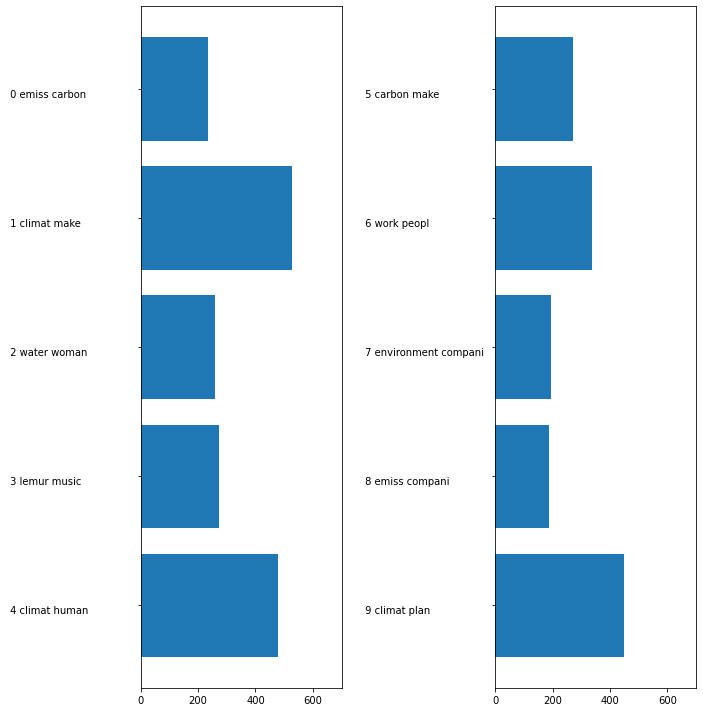

In [43]:
lda_model(data_stemmed)

## 3. Get the topics that make up an article
Reversing the LDA model proved to be a bit complex. After trying out a few things I found a good solution which is presented in the notebook *04_LDA_topic_distribution*. The following section is the attempt at a prediction model to find out which topics make up an unseen article. (i.e. converting unsupervised output to a supervised problem).

Please note: Due to time constraints, this is purerly a test for functionality as EDA was not yet performed and there is still further data cleaning to be implemented. The results of the supervised model sub-sub-optmial.

### 3.1 Subsetting data to articles that successfully converted users

In [ ]:
with open('../02_LDA_model/pkl_cellar/success_urls.pkl', 'rb') as file:
    success_urls = pickle.load(file)
    
success_urls

In [ ]:
test_text = [success_urls.loc[14].content, success_urls.loc[644].content, success_urls.loc[3156].content, 
             success_urls.loc[16].content, success_urls.loc[209].content, success_urls.loc[3080].content, 
             success_urls.loc[700].content, success_urls.loc[171].content, success_urls.loc[273].content]
test_text

## 4. Using this [medium article](https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28) to use our unsupervised model's reults as a supervised model to get the topic distributions for each article.

### 4.1 Unfortunately, even though I've already gone through data cleaning, I need to see which format (data type) is being used for the model, so I'll need to rerun the data cleaning according to this article.

In [ ]:
import gensim
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [ ]:
def remove_stopwords(texts):
    out = [[word for word in simple_preprocess(str(doc))
            if word not in stop_words]
            for doc in texts]
    return out

In [ ]:
# this list of lists of words is just the articles tokenized

remove_stopwords(test_text)

In [ ]:
# I want to implement bi-grams in the initial data cleaning process
# but I need to see the output datatype now

def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

In [ ]:
bigrams(remove_stopwords(test_text), bi_min=15, tri_min=10)

In [ ]:
def get_corpus(df):

    words = list((df.content))
    words = remove_stopwords(words)
    bigram_mod = bigrams(words)
    bigram = [bigram_mod[article] for article in words]
    id2word = gensim.corpora.Dictionary(bigram)
    
    # removes most common and rare words
    # it's possible I need to get rid of this one
    # id2word.filter_extremes(no_below=10, no_above=0.35)
    
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    
    return corpus, id2word, bigram

In [ ]:
train_corp, train_id2w, train_bigram = get_corpus(success_urls)

In [ ]:
import warnings
import logging
logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_train = gensim.models.ldamulticore.LdaMulticore(corpus=train_corp,
                                                        num_topics=10,
                                                        id2word=train_id2w,
                                                        chunksize=100,
                                                        #workers=7, # Num. Processing Cores - 1
                                                        passes=50,
                                                        eval_every=1,
                                                        per_word_topics=True)
    lda_train.save('lda_train.model')

In [ ]:
lda_train.print_topics(20, num_words=15)[:10]

### 4.2 Now we move on to creating vectors that will be the basis of our training model. This is comprised of topic distributions for each article

In [ ]:
len(success_urls)

In [ ]:
success_urls.index[0]

In [ ]:
train_vecs = []
for i in range(len(success_urls)):
    # min_probability = 0.0 will show distribution of all 10 topics
    # I may change this depending on how the output looks and what we actually need
    top_topics = lda_train.get_document_topics(train_corp[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(10)]
    # attaches index of article to vector, 
    # can also be done for previous attempt
    topic_vec.extend([success_urls.index[i]]) 
    train_vecs.append(topic_vec)


In [ ]:
train_vecs

### 4.3 Time to train the actual model. This is still a test set, if this works I will train the model on the big dataset (complete academy) and test it on the succes_urls.

For training we need an actual prediction, in this case it would be a success measure. We can use the goal completions, but I'll actually need to add it to the df.

In [ ]:
success_urls

In [ ]:
X = np.array(train_vecs)
y = np.array(success_urls.target_g13)

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
# 1/5 of content are held out as validation data on each
# fold, then f1 scores are averaged

kf = KFold(5, shuffle=True, random_state=42)

In [ ]:
# logistic regression, stochastic gradient descent with log loss
# and stochastic gradient descent with modified huber loss
cv_lr_f1, cv_lrsgd_f1, cv_svcsgd_f1,  = [], [], []

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.metrics import f1_score

In [42]:
for train_ind, val_ind in kf.split(X, y):
    # Assign CV IDX
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind]
    
    # Scale Data
    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_val_scale = scaler.transform(X_val)
    
    # Logisitic Regression (may need to balance weights
    # depends on results)
    lr = LogisticRegression(class_weight= 'balanced', 
                            solver='newton-cg', 
                            fit_intercept=True).fit(X_train_scale, y_train)
    
    # May need to change the average, macro is for unweighted mean
    # CHECK all f1 scores
    y_pred = lr.predict(X_val_scale)
    cv_lr_f1.append(f1_score(y_val, y_pred, average='macro'))
    
    # Logistic Regression SGD
    sgd = (linear_model.SGDClassifier(max_iter=1000, 
                                      tol=1e-3,
                                      loss='log', 
                                      class_weight='balanced')
                       .fit(X_train_scale, y_train))
    
    y_pred = sgd.predict(X_val_scale)
    cv_lrsgd_f1.append(f1_score(y_val, y_pred, average='micro'))
    
    # SGD Modified Huber
    sgd_huber = (linear_model.SGDClassifier(max_iter=1000, 
                                           tol=1e-3, 
                                           alpha=20, 
                                           loss='log',
                                           class_weight='balanced')
                             .fit(X_train_scale, y_train))
    
    y_pred = sgd_huber.predict(X_val_scale)
    cv_svcsgd_f1.append(f1_score(y_val, y_pred, average='micro'))

print(f'Logistic Regression Val f1: {np.mean(cv_lr_f1):.3f} +- {np.std(cv_lr_f1):.3f}')
print(f'Logisitic Regression SGD Val f1: {np.mean(cv_lrsgd_f1):.3f} +- {np.std(cv_lrsgd_f1):.3f}')
print(f'SVM Huber Val f1: {np.mean(cv_svcsgd_f1):.3f} +- {np.std(cv_svcsgd_f1):.3f}')

Logistic Regression Val f1: 0.222 +- 0.030
Logisitic Regression SGD Val f1: 0.323 +- 0.067
SVM Huber Val f1: 0.419 +- 0.196


hahahahahah these are just awful, but it's possible I'm using the wrong models for the purposes of this project. Also possible that the data set is too small or I'm using the wrong settings. Will need to do some research on how best to approach this.